In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import dask
from dask.diagnostics import ProgressBar

import warnings, os

from linearsim import jonswap, freqs, spectra_stats
from distfit import get_distribution #This function takes a dataset of fit coefficents and returns a scipy statistical distribution

In [5]:
# Labels and colours for plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels={'Hs':'$H_s$','Tz':'$T_z$','Hmax':'$H_{max}$','HmHs':'$H_{max}/H_s$','r_spectra':'$r_{sp}$','r_sample':'$r_{s}$'}
N = {10:'-',20:'--',100:':',200:'-.'}
gamma = {1:colors[0],3.3:colors[1],7:colors[2]}

# Load the model coefficients

In [6]:
suffix='_model_221112'
n_seed=25000
with open(f'data/model/Model_Coefficients{suffix}.yaml',mode='rt') as f:
    ds_model=xr.Dataset.from_dict(yaml.safe_load(f))
ds_model

<xarray.Dataset>
Dimensions:             (coeff: 3, variable: 5, parameter: 3, term: 2)
Coordinates:
  * coeff               (coeff) <U9 'gamma^2' 'gamma' 'Intercept'
    distribution        (variable) <U10 'genextreme' ... 'genextreme'
  * parameter           (parameter) <U5 'loc' 'scale' 'shape'
  * term                (term) <U5 'const' 'x1'
  * variable            (variable) <U8 'HmHs' 'Hmax' 'Hs' 'Tz' 'r_sample'
Data variables: (12/24)
    0.025               (variable, parameter, term, coeff) float64 0.001109 ....
    0.975               (variable, parameter, term, coeff) float64 0.001511 ....
    AIC                 (variable, parameter, term) float64 -159.5 ... -99.33
    Adj. R-squared      (variable, parameter, term) float64 0.998 ... 0.575
    BIC                 (variable, parameter, term) float64 -157.2 ... -97.01
    Coef.               (variable, parameter, term, coeff) float64 0.00131 .....
    ...                  ...
    Std.Err.            (variable, parameter, term, coeff) float64 9.303e-05 ...
    equation            (variable, parameter) <U49 '$loc$ = x1.$(\\logN)^{0.6...
    t                   (variable, parameter, term, coeff) float64 14.08 ... ...
    xpow                (variable, parameter) float64 0.6667 1.0 0.5 ... 1.0 1.0
    xtran               (variable, parameter) <U4 'log' 'noop' ... 'log' 'log'
    ytran               (variable, parameter) <U4 'noop' 'noop' ... 'log' 'log'

# Open the simulation results 

In [9]:
fn = f'data/timeseries_stats/RAS_n{n_seed}{suffix}.nc'
ds = xr.open_dataset(fn)
ds['HmHs'] = ds['Hmax']/ds['Hs']

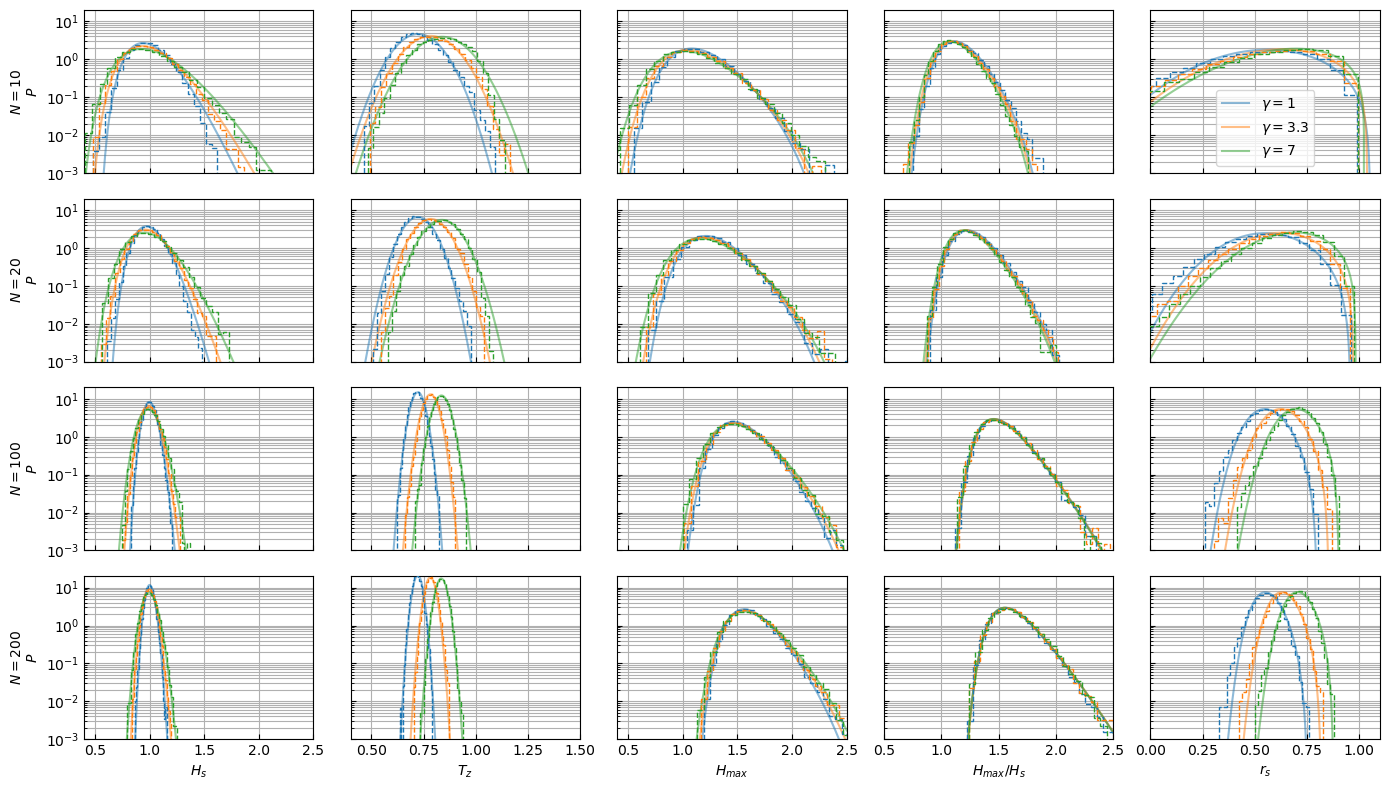

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

limits={'Hs':(0.4,2.5),'Tz':(0.4,1.5),'Hmax':(0.4,2.5),'HmHs':(0.5,2.5),'r_sample':(0.0,1.1)}

fig,axs = plt.subplots(len(N),len(limits),figsize=(14,8),sharey=True,sharex='col')

for j,(v,l) in enumerate(limits.items()):
    for i,(n,ls) in enumerate(N.items()):  
        ax = axs[i,j]      
        for g,c in gamma.items():
            d = get_distribution(ds_model,v,g,n)
            x = np.linspace(l[0],l[1],500)
            # p = 1-d.cdf(x)
            p = d.pdf(x)
            ax.semilogy(x,p,ls='-',c=c,label=f'$\gamma={g}$',alpha=0.5)
            ax.set_ylim(1E-3,20)

            sample = ds.sel(gamma=g,n=n)[v].values.ravel()
            ecdf = ECDF(sample)
            # ax.semilogy(ecdf.x,(1-ecdf.y),ls='--',lw=1.0,c=c)
            # ax.scatter(ecdf.x[::5],(1-ecdf.y[::5]),25,marker='+',c=c)
            ax.hist(sample,bins=25,density=True,alpha=1.0,color=c,histtype='step',ls='--',zorder=100)

        ax.grid(which='both')
        ax.set_xlim(l)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(which='both',direction='in')

        if i == len(N)-1:
            ax.set_xlabel(labels[v])

        if j == 0:
            ax.set_ylabel(f'$N={n}$\n$P$')
            yticks=10.**np.arange(-4,1)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)
  
axs[0,-1].legend()
fig.tight_layout()
fig.savefig('figures/model_validation/ParametricModelValidation_PDF.pdf',bbox_inches='tight')

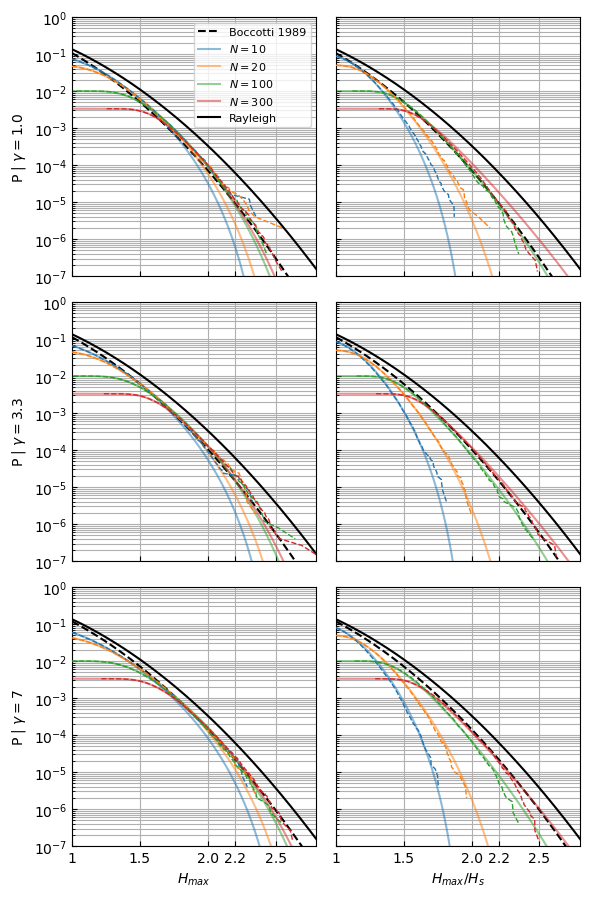

In [13]:
rayleigh = ss.rayleigh(0,0.5)

Nn=[10,20,100,300]
Gg = [1.0,3.3,7]
Vv = ['Hmax','HmHs']
fig,axs = plt.subplots(len(Gg),len(Vv),figsize=(6,9),sharey=True,sharex=True)
for i,g in enumerate(Gg):
    for j,v in enumerate(Vv):
        x = np.linspace(1.0,3.1,500)
        ax = axs[i,j]

        # Characteristic spectra to calculate published empirical fits
        f,df = freqs(512,1/32)
        js = jonswap(f,1.0,1.0,g)
        Hm0, Tm01, a, s, b, r_m = spectra_stats(f,js)

        # Boccotti 1989
        c0 = (1+b)/(np.sqrt(2*b*(1-a)))
        c1 = 1/(4*(1-a))
        p = c0*np.exp(-c1*(4.004*x)**2) # heights in the data are normalised by 2*sqrt(m0)
        ax.plot(x,p,ls='--',color='k',label='Boccotti 1989')

        for ni,n in enumerate(Nn):

            c = colors[ni]
            d = get_distribution(ds_model,v,g,n)
            
            p = 1-d.cdf(x)
            pind = p>0
            p = p[pind]/n
            # p = np.log(-np.log(p/n))
            ax.plot(x[pind],p,ls='-',c=c,label=f'$N={n}$',alpha=0.5)

            sample = ds.sel(gamma=g,n=n)[v].values.ravel()
            ecdf = ECDF(sample)
            p=1-ecdf.y
            pind = p>0
            p = p[pind]/n
            # p = np.log(-np.log(p/n))
            # ax.scatter(ecdf.x[pind],p,25,c=c,marker='+',alpha=1.0,edgecolors='none',label=f'$N={n}$')
            ax.plot(ecdf.x[pind],p,lw=1.0,c=c,ls='--',zorder=100)


        # Rayleigh
        p = 1-rayleigh.cdf(x)
        ax.plot(x,p,ls='-',color='k',label='Rayleigh')
        
        ax.set_xlim([1,2.8])
        xticks = [1,1.5,2.0,2.2,2.5]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        
        # ax.set_ylim(0.7,3.5)
        ax.set_yscale('log')
        ax.set_ylim(1E-7,1)

        ax.grid(which='both')
        ax.tick_params(which='both',direction='in')
        axs[-1,j].set_xlabel(labels[v])

    axs[i,0].set_ylabel(f'P | $\gamma={g}$')
axs[0,0].legend(fontsize=8)
fig.tight_layout()
fig.savefig('figures/model_validation/ExtemeHeights.pdf',bbox_inches='tight')

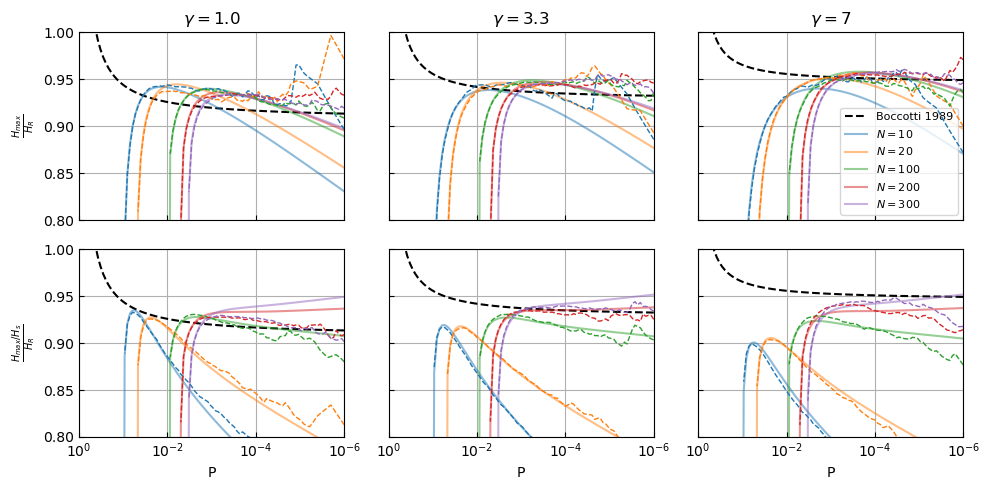

In [14]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)#ignore divide by 0 warning
    
    Nn=[10,20,100,200,300]
    # Nn=[512,]
    Gg = [1.0,3.3,7]
    Vv = ['Hmax','HmHs']
    fig,axs = plt.subplots(len(Vv),len(Gg),figsize=(10,5),sharey=True,sharex=True)
    for j,g in enumerate(Gg):
        for i,v in enumerate(Vv):
            x = np.linspace(0,3.1,500)
            ax = axs[i,j]
            # Characteristic spectra
            f,df = freqs(512,1/32)
            js = jonswap(f,1.0,1.0,g)
            Hm0, Tm01, a, s, b, r_m = spectra_stats(f,js)

            # Rayleigh
            p_r = 1-rayleigh.cdf(x)
            p_i = np.linspace(-6,0,100)

            y_r=np.log10(p_r)
            inds = np.argsort(y_r)
            x_r=np.interp(p_i,y_r[inds],x[inds])

            # Boccotti 1989
            c0 = (1+b)/(np.sqrt(2*b*(1-a)))
            c1 = 1/(4*(1-a))
            p_b = c0*np.exp(-c1*(4.004*x)**2) # heights in the simulations are normalised by 4*sqrt(m0), but previous work use sqrt(m0)
            y_b = np.log10(p_b)
            inds = np.argsort(y_b)
            x_b=np.interp(p_i,y_b[inds],x[inds])

            ax.plot(10**p_i,x_b/x_r,ls='--',color='k',label='Boccotti 1989')

            for ni,n in enumerate(Nn):

                # g=3.5
                c=colors[ni]
                d = get_distribution(ds_model,v,g,n)
                
                p_d = 1-d.cdf(x)

                p_d = p_d/n
                y_d = np.log10(p_d)
                inds = np.argsort(y_d)
                x_d=np.interp(p_i,y_d[inds],x[inds])
                # p = p/p_r
                # p = np.log(-np.log(p/n))
                ax.plot(10**p_i,x_d/x_r,ls='-',c=c,label=f'$N={n}$',alpha=0.5)

                sample = ds.sel(gamma=g,n=n)[v].values.ravel()
                ecdf = ECDF(sample)
                p_s=1-ecdf.y

                p_s = p_s/n
                y_s = np.log10(p_s)
                inds = np.argsort(y_s)
                x_s=np.interp(p_i,y_s[inds],ecdf.x[inds])
                ax.plot(10**p_i,x_s/x_r,lw=1.0,c=c,ls='--',zorder=100)

            ax.set_ylim(0.80,1)
            ax.set_xscale('log')
            ax.set_xlim(1,1E-6)

            ax.grid(which='both')
            ax.tick_params(which='both',direction='in')
            axs[i,0].set_ylabel(f'$\\frac{{{labels[v].replace("$","")}}}{{H_R}}$')

            axs[0,j].set_title(f'$\gamma={g}$')
            axs[-1,j].set_xlabel(f'P')
    axs[0,-1].legend(loc='lower right',fontsize=8)
    fig.tight_layout()
    fig.savefig('figures/model_validation/ExtemeHeights_Normalised.pdf',bbox_inches='tight')

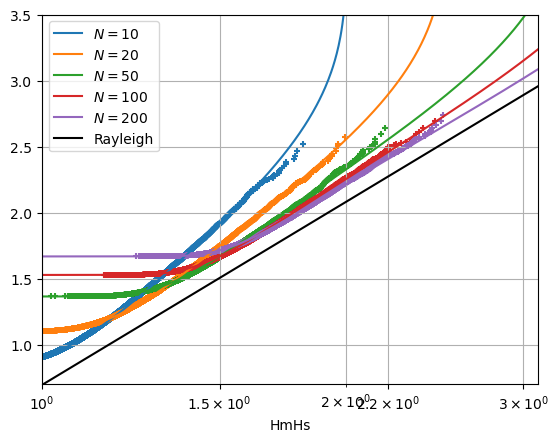

In [15]:
Nn=[10,20,50,100,200]

for v in ['HmHs']:
    fig,ax = plt.subplots()
    for i,n in enumerate(Nn):
        for g in [3.3]:
            # g=3.5
            c=colors[i]
            d = get_distribution(ds_model,v,g,n)
            x = np.linspace(1.0,3.1,500)
            p = 1-d.cdf(x)
            pind = p>0
            p = p[pind]
            p = np.log(-np.log(p/n))
            ax.semilogx(x[pind],p,ls='-',c=c,label=f'$N={n}$')

            sample = ds.sel(gamma=g,n=n)[v].values.ravel()
            ecdf = ECDF(sample)
            p=1-ecdf.y
            pind = p>0
            p = p[pind]
            p = np.log(-np.log(p/n))
            ax.scatter(ecdf.x[pind],p,25,c=c,marker='+')
            
    ax.set_xlabel(v)
    p = 1-rayleigh.cdf(x)
    p = p
    ax.semilogx(x,np.log(-np.log(p)),ls='-',color='k',label='Rayleigh')
    ax.legend(loc='upper left')
    ax.grid(which='both')
    ax.set_xlim([1,3.1])
    ax.set_xticks([1,1.5,2.2,3])
    ax.set_ylim(0.7,3.5)

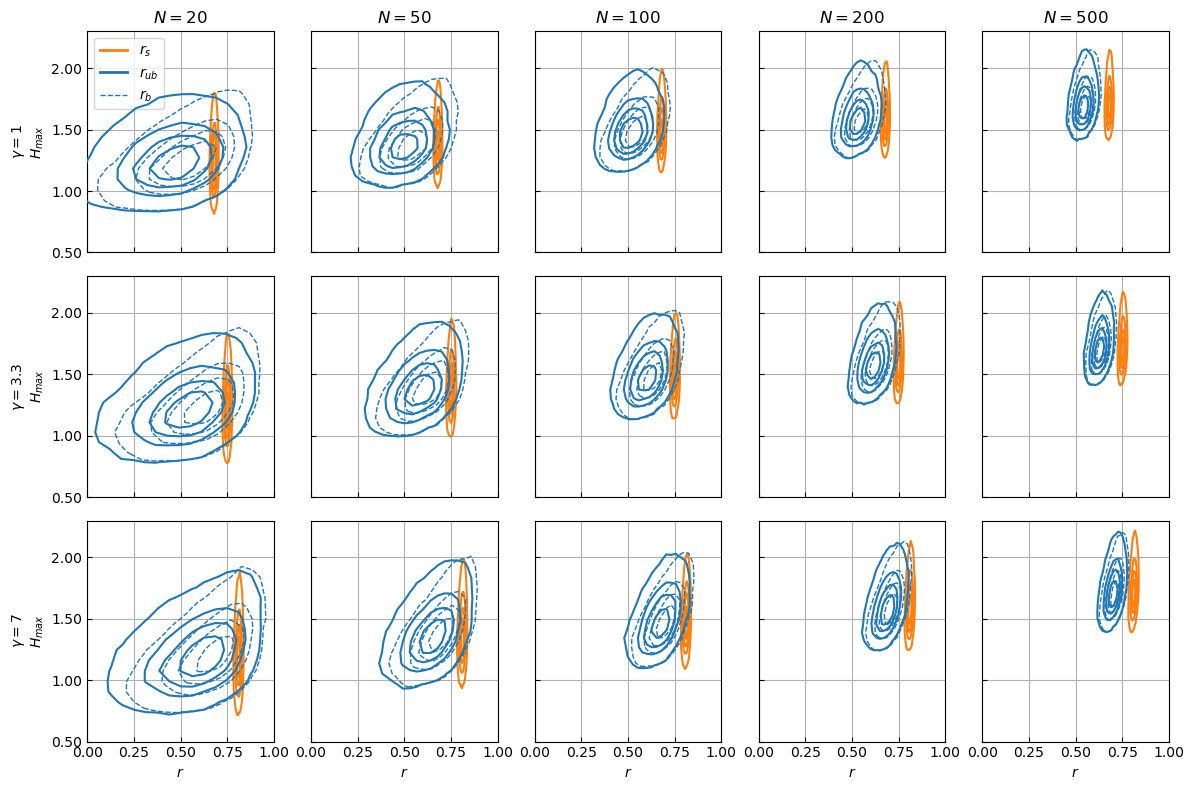

In [31]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

N = [20,50,100,200,500]
gamma = [1,3.3,7]

n_bins = 25
levels = 5

fig,axs = plt.subplots(len(gamma),len(N),figsize=(12,8),sharex=True,sharey=True)
for i,g in enumerate(gamma):
    for j,n in enumerate(N):
        # print(g,n)
        ax = axs[i,j]
        data = ds.sel(n=n,gamma=g)[['Hmax','r_sample','r_spectra','r_unbiased']].to_dataframe()
        y = data['Hmax']

        x1 = data['r_sample']
        x2 = data['r_spectra']
        x3 = data['r_unbiased']
        sns.kdeplot(ax=ax,x=x2,y=y,levels=levels,gridsize=n_bins,color=colors[1],log_scale=(False,False),label='$r_s$')
        sns.kdeplot(ax=ax,x=x1,y=y,levels=levels,gridsize=n_bins,color=colors[0],log_scale=(False,False),linestyles='dashed',linewidths=1.0,label='$r_b$')
        sns.kdeplot(ax=ax,x=x3,y=y,levels=levels,gridsize=n_bins,color=colors[0],log_scale=(False,False),zorder=100,label='$r_{ub}$')
        ax.grid('both')
        ax.set_xlim(0,1)
        ax.set_ylim(0.5,2.3)
        # ax.set_yticks([1.0, 1.5, 2.0])
        formatter = FormatStrFormatter('%.2f')
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)
        ax.tick_params(which='both',direction='in')

        if j == 0:
            ax.set_ylabel(f'$\gamma={g}$\n$H_{{max}}$')

        if i == 0:
            ax.set_title(f'$N={n}$')
        if i == len(gamma)-1:
            ax.set_xlabel('$r$')


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[0], lw=1, ls='--')]
axs[0,0].legend(custom_lines, ['$r_s$', '$r_{ub}$', '$r_b$'],loc='upper left')

fig.tight_layout()
fig.savefig('figures/model_validation/HmaxPredictability.pdf',bbox_inches='tight')